# **Mini Project 1 – News Comparison Analysis by Ashish Dahal**
In this project we will be comparing the news published between December 2019 and December 2020 from one of the wall street journal website.

## **Part 1 & 2- Web Scraping and Data Processing**
**Scraping data from [The Wall Street Journal](https://www.wsj.com/news/archive).**

Importing Essential Libraries

In [ ]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Data Scraping and Processing

In [ ]:
# HTTP headers
HEADERS = {"User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/77.0.3865.90 Safari/537.36"}

# Storing the extracted data as nested lists. Initializing with the column names.
article_list = [["id", "title", "author", "category","year", "month", "day", "link"]] 

# URL of the website to scrape and years for which we will scrape the articles
URL = 'https://www.wsj.com/news/archive'
YEARS = ['2019', '2020']
id = 0 # initializing article ID

# UTILITY FUNCTIONS
#####################################################################################################################################################
def fetch_articles(URL, year, month, day, page=1, recursive=False):
  """Fetches all the articles data from the given website for the given date 

    Parameters:
    URL (string): URL of the website to be scraped
    year (string): Year of the article published
    month: month of the article published
    day: day of the article published
    page: article page number
    recursive: if the function is being used as recursive for fetching next pages of the same date
    

    Returns:
    list: id, title, author, category, year, month, day and link of the article

   """


  # Modifying global ID value to ensure correct ID continuity
  global id

  # Storing extracted article data as a local list
  a_list = []

  # Setting default number of pages
  pages = 1
  
  # Requesting HTML content from the website
  response = requests.get(f'{URL}/{year}/{month}/{day}?page={page}', headers=HEADERS)

  # Extracting data with BeautifulSoup library
  soup = BeautifulSoup(response.text, 'lxml')
  articles = soup.find_all(('article'))

  # Logic for recursively using this function for extracting data from multiple pages
  # Executes for the first page
  if not recursive:
    # finding the number of pages to scrape
    pages_html = soup.find('span', class_='WSJTheme--pagepicker-total--Kl350I1l')
    if pages_html != None:
      pages = pages_html.string 
      pages = int([int(word) for word in pages.split() if word.isdigit()][0])
  
  # Main logic for extracting title, article link, category and adding to the list
  for article in articles:
    title = article.find('span', class_='WSJTheme--headlineText--He1ANr9C').string
    link = article.find('a', href=True)['href']
    category = article.find('div', class_= 'WSJTheme--articleType--34Gt-vdG').find_all('span')[-1:][0].string
    a_list.append([id, title, fetch_author(link), category, year, month, day, link])
    id += 1

  # Scraping remaining pages
  if pages > 1 and not recursive:
    for page_no in range(2,pages+1, 1):
      a_list += fetch_articles(URL, year, month, day, page_no, True)

  # Returning the extracted articles data for a particular date
  return a_list
  
#################################################################################################################################################
def fetch_author(link):
  """Returns the author from the given article link"""

  author = 'N/A'

  ### CODE BELOW IS COMMENTED 
  ### REASON: OVERHEAD TIME OF FETCHING AUTHORS FROM INDIVIDUAL ARTICLE LINKS IS ~29 MINS VS ~1 MINS WITHOUT SCRAPING AUTHOR
  ### CAN BE UNCOMMENTED AND RUN 

  # if link != None:
  #   article_html = requests.get(link, headers=HEADERS)
  #   soup = BeautifulSoup(article_html.text, 'lxml')
  #   author = soup.find('span', class_='author-name')
  #   if author == None:
  #     author = soup.find('button', class_='author-button')
  #   if author != None:
  #     return author.string
  #   else:
  #     author = 'N/A'

  return author
#################################################################################################################################################


In [ ]:
# Fecting articles for first two weeks of december 2019 and december 2020
for year in YEARS:
  for day in range(1,15,1): 
    article_list = article_list + fetch_articles(URL, str(year), '12' , str(day).zfill(2))

## **Part 3 - Exploratory Data Analysis**

In [ ]:
# Setting maximum row and column width for viewing the DataFrame
pd.set_option('max_rows', 5000)
pd.set_option('max_colwidth', 400)

# Creating a DataFrame from scraped list of articles
df = pd.DataFrame(article_list[1:], columns=article_list[0]) # first list is the column names
df.sample(10)

,id,title,author,category,year,month,day,link
1548,1548,On Decriminalizing Small Amounts of Drugs,N/A,Letters,2020,12,02,https://www.wsj.com/articles/on-decriminalizing-small-amounts-of-drugs-11606945070
708,708,"Juice WRLD, a Young Star of Hip-Hop, Dies",N/A,Music,2019,12,08,https://www.wsj.com/articles/juice-wrld-a-young-star-of-hip-hop-dies-11575832316
1073,1073,Suu Kyi Defends Myanmar Against Rohingya Genocide Allegations,N/A,Asia,2019,12,11,https://www.wsj.com/articles/aung-san-suu-kyi-defends-myanmar-against-rohingya-genocide-allegations-11576076183
1397,1397,Drought Leaves Southern Africa High and Dry,N/A,Africa,2019,12,14,https://www.wsj.com/articles/a-fine-for-a-flush-drought-leaves-southern-africa-high-and-dry-11576324800
275,275,New Problems With Takata Air Bags Prompt Recall of 1.4 Million Cars,N/A,Autos Industry,2019,12,04,https://www.wsj.com/articles/new-problems-with-takata-air-bags-prompt-recall-of-1-4-million-cars-11575515128
249,249,Group Backed by Top Chinese University Fails to Repay Creditors,N/A,Markets,2019,12,03,https://www.wsj.com/articles/group-backed-by-top-chinese-university-fails-to-repay-creditors-11575371252
586,586,"Fed Adds $72.8 Billion to Markets, Balance Sheet Moves to $4.07 Trillion",N/A,Markets,2019,12,06,https://www.wsj.com/articles/fed-adds-72-8-billion-to-markets-balance-sheet-moves-to-4-07-trillion-11575642409
1503,1503,Credit Suisse Taps Lloyds Boss as Next Chairman,N/A,Markets,2020,12,01,https://www.wsj.com/articles/credit-suisse-taps-lloyds-boss-as-next-chairman-11606818366
2334,2334,The Best Books of 2020: Politics,N/A,Bookshelf,2020,12,10,https://www.wsj.com/articles/the-best-books-of-2020-politics-11607642313
1469,1469,Airbnb IPO Terms Send Valuation as High as $35 Billion,N/A,IPOs,2020,12,01,https://www.wsj.com/articles/airbnb-sets-ipo-terms-sending-valuation-as-high-as-35-billion-11606835610


Sidenote: Code for saving the data from google colab into google drive. (To not scrape data everytime we run the notebook)
```
df.to_csv('data.csv')
from google.colab import drive
drive.mount('drive')
!cp data.csv "drive/My Drive/"
```

In [ ]:
# Checking if there are any missing values ('author' values were intentionally assigned 'N/A')
df.isnull().any()

id          False
title       False
author      False
category    False
year        False
month       False
day         False
link        False
dtype: bool

In [ ]:
# Checking no. of articles scraped
len(df)

2776

In [ ]:
# Checking number of articles published each year
df.groupby(['year'])['title'].count()

year
2019    1405
2020    1371
Name: title, dtype: int64

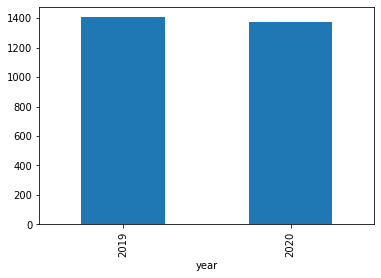

In [ ]:
df.groupby(['year'])['title'].count().plot.bar();


There is not much difference in the number of articles published in december 2019 and 2020, though its a bit less in 2020.

Visualizing the articles publication throughout December 2019 and December 2020:

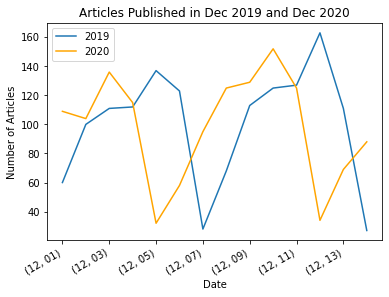

In [ ]:
ax1 = df[df['year'] == '2019'].groupby(['month','day'])['title'].count().plot.line()
ax2 = df[df['year'] == '2020'].groupby(['month','day'])['title'].count().plot.line(color='orange')

ax1.set(xlabel='Date', ylabel='Number of Articles', title="Articles Published in Dec 2019 and Dec 2020")
plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.rcParams["figure.figsize"] = (10, 5)
plt.legend(['2019','2020'])
plt.show()

A similar pattern of article publication can be seen in December 2019 and December 2020, according to the graph. Weekends are to account for the drop in the amount of articles published at specific intervals.

On average, the titles have 53 characters


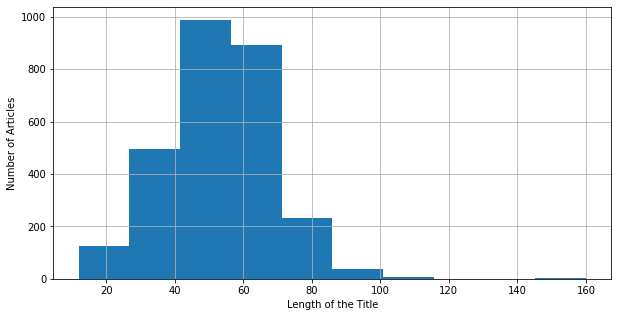

In [ ]:
# Looking the the title length

plt.xlabel("Length of the Title")
plt.ylabel("Number of Articles")
plt.rcParams["figure.figsize"] = (10, 5)
print(f"On average, the titles have {df['title'].str.len().mean():.0f} characters")
df['title'].str.len().hist();

Looking at the category distribution of titles:

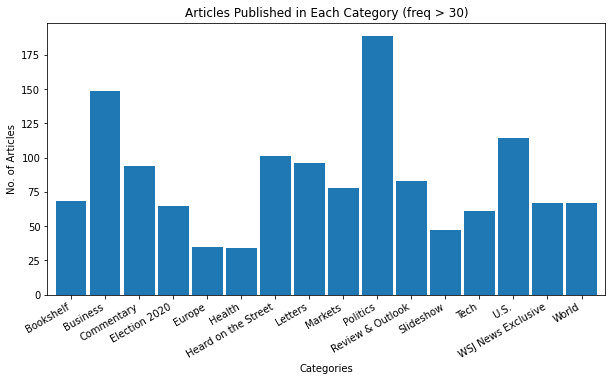

In [ ]:
# Omiting infrequent article categories (occurring less than 30 times)
freq_categories = df.groupby(['category'])['title'].count()
freq_categories = freq_categories[freq_categories > 30]


# Plotting the bar graph
ax = freq_categories.plot.bar(width=0.9)

ax.set(xlabel='Categories', ylabel='No. of Articles', title="Articles Published in Each Category (freq > 30)")
plt.rcParams["figure.figsize"] = (10, 10)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

plt.show()

From above graph, we can see that highest number of news is published on the 'Politics' and followed by 'Business' category. It shows that the readers are more interested in political and business news compared to others.

**Cleaning and processing the titles to analyse in the form of wordcloud:**

In [ ]:
# Importing Natural Language Toolkit Library
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize

# Installing Contractions Libirary
!pip install contractions
import contractions

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
import regex

title_frame = df.loc[:,['title','year']]

# mapping contraction
title_frame['title_tokens'] = title_frame['title'].apply(lambda x: [contractions.fix(word) for word in x.split()])
title_frame['title'] = [''.join(map(str, word)) for word in title_frame['title']]

# lowercasing and cleaning noise
title_frame['title'] = title_frame['title'].str.lower()
title_frame['title'] = title_frame['title'].apply(lambda x: regex.sub(r'[^\w\d\s\']+', '', x))

# tokenization
title_frame['tokenized_title'] = title_frame['title'].apply(word_tokenize)
title_frame.sample(10, random_state = 5)

title_frame.sample(10)

,title,year,title_tokens,tokenized_title
1001,doj watchdog testifies about his report on fbis russia probe,2019,"[DOJ, Watchdog, Testifies, About, His, Report, on, FBI’s, Russia, Probe]","[doj, watchdog, testifies, about, his, report, on, fbis, russia, probe]"
86,hop skip go review going mobile,2019,"[‘Hop,, Skip,, Go’, Review:, Going, Mobile]","[hop, skip, go, review, going, mobile]"
1070,aramco the second trillion is the hardest,2019,"[Aramco:, The, Second, Trillion, Is, the, Hardest]","[aramco, the, second, trillion, is, the, hardest]"
206,twitter plans first sale of highyield debt,2019,"[Twitter, Plans, First, Sale, of, High-Yield, Debt]","[twitter, plans, first, sale, of, highyield, debt]"
1177,one of the biggest homes in the hollywood hills sells for 355 million,2019,"[One, of, the, Biggest, Homes, in, the, Hollywood, Hills, Sells, for, $35.5, Million]","[one, of, the, biggest, homes, in, the, hollywood, hills, sells, for, 355, million]"
2681,gen mark milley the biggest security challenges for the us,2020,"[Gen., Mark, Milley:, The, Biggest, Security, Challenges, for, the, you.S.]","[gen, mark, milley, the, biggest, security, challenges, for, the, us]"
2172,covid19 remote work make austin a magnet for new jobs,2020,"[Covid-19,, Remote, Work, Make, Austin, a, Magnet, for, New, Jobs]","[covid19, remote, work, make, austin, a, magnet, for, new, jobs]"
2462,pfizers covid19 vaccine distribution side effects and everything you need to know,2020,"[Pfizer’s, Covid-19, Vaccine:, Distribution,, Side, Effects, and, Everything, You, Need, to, Know]","[pfizers, covid19, vaccine, distribution, side, effects, and, everything, you, need, to, know]"
1585,tips for applying to 2021 mba programs,2020,"[Tips, for, Applying, to, 2021, M.B.A., Programs]","[tips, for, applying, to, 2021, mba, programs]"
41,privateequity cash piles up as takeover targets get pricier,2019,"[Private-Equity, Cash, Piles, Up, as, Takeover, Targets, Get, Pricier]","[privateequity, cash, piles, up, as, takeover, targets, get, pricier]"


In [ ]:
# importing stopword library and initializing
nltk.download('stopwords')
from nltk.corpus import stopwords
my_stopwords = set(stopwords.words('english'))

# removing stopwords
title_frame['tokenized_title'] = title_frame['tokenized_title'].apply(lambda x: [word for word in x if word not in my_stopwords])
title_frame['joined_tokenized_titles'] = [' '.join(map(str, word)) for word in title_frame['tokenized_title']]

title_frame.sample(10)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,title,year,title_tokens,tokenized_title,joined_tokenized_titles
117,shipbuilding executive found not guilty in mozambique debt fraud trial,2019,"[Shipbuilding, Executive, Found, Not, Guilty, in, Mozambique, Debt, Fraud, Trial]","[shipbuilding, executive, found, guilty, mozambique, debt, fraud, trial]",shipbuilding executive found guilty mozambique debt fraud trial
1937,pompeo is set to begin domestic chapter,2020,"[Pompeo, Is, Set, to, Begin, Domestic, Chapter]","[pompeo, set, begin, domestic, chapter]",pompeo set begin domestic chapter
484,saudirussia committee recommends deeper oil cuts,2019,"[Saudi-Russia, Committee, Recommends, Deeper, Oil, Cuts]","[saudirussia, committee, recommends, deeper, oil, cuts]",saudirussia committee recommends deeper oil cuts
2514,netflixs truecrime character assassination,2020,"[Netflix’s, True-Crime, Character, Assassination]","[netflixs, truecrime, character, assassination]",netflixs truecrime character assassination
490,low interest rates leave retired investors with tough choices,2019,"[Low, Interest, Rates, Leave, Retired, Investors, With, Tough, Choices]","[low, interest, rates, leave, retired, investors, tough, choices]",low interest rates leave retired investors tough choices
1843,model portfolios surging as advisers seek quick ways to invest,2020,"[Model, Portfolios, Surging, as, Advisers, Seek, Quick, Ways, to, Invest]","[model, portfolios, surging, advisers, seek, quick, ways, invest]",model portfolios surging advisers seek quick ways invest
180,report reveals call records between giuliani white house and nunes,2019,"[Report, Reveals, Call, Records, Between, Giuliani,, White, House, and, Nunes]","[report, reveals, call, records, giuliani, white, house, nunes]",report reveals call records giuliani white house nunes
759,why im not an antidentite,2019,"[Why, I am, Not, an, Anti-Dentite]","[im, antidentite]",im antidentite
25,free speech and profanity,2019,"[Free, Speech, and, Profanity]","[free, speech, profanity]",free speech profanity
94,new york city braces for up to 6 inches of snow,2019,"[New, York, City, Braces, for, Up, to, 6, Inches, of, Snow]","[new, york, city, braces, 6, inches, snow]",new york city braces 6 inches snow


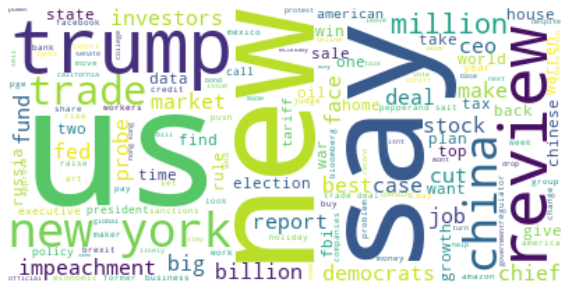

In [ ]:
# Generating word cloud from joined tokenized title

from wordcloud import WordCloud

wc = WordCloud(background_color="white")

# word cloud for 2019
title_2019 = title_frame[title_frame['year'] == '2019']
wordcloud_2019 = wc.generate(' '.join(title_2019['joined_tokenized_titles'].apply(str)))
plt.imshow(wordcloud_2019, interpolation='bilinear')

plt.axis('off')
plt.show()

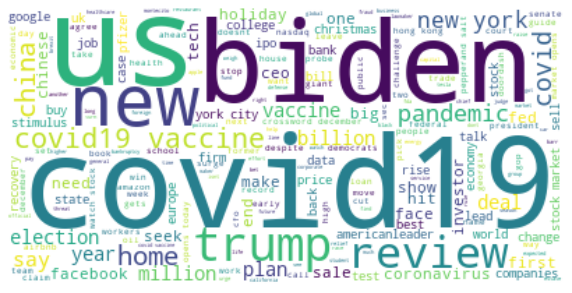

In [ ]:
# word cloud for 2020
title_2020 = title_frame[title_frame['year'] == '2020']
wordcloud_2020 = wc.generate(' '.join(title_2020['joined_tokenized_titles'].apply(str)))
plt.imshow(wordcloud_2020, interpolation='bilinear')
plt.axis('off')
plt.show()

As we can see, in December 2019, the news titles were mostly related to United States(U.S), Donald Trump, Impeachment, China, Trade etc. It might be because of Donald Trump's outrageous remarks on china, the trade war and also the discussion about Trumps's impeachment.


However, the news titles in 2019 were dominated by COVID-19 and vaccine, Joe Biden (as he became the president), Trump etc.

## **Part 4 - Comparison analysis study**
Visualising and comparing the topic distribution between December 2019 and December 2020

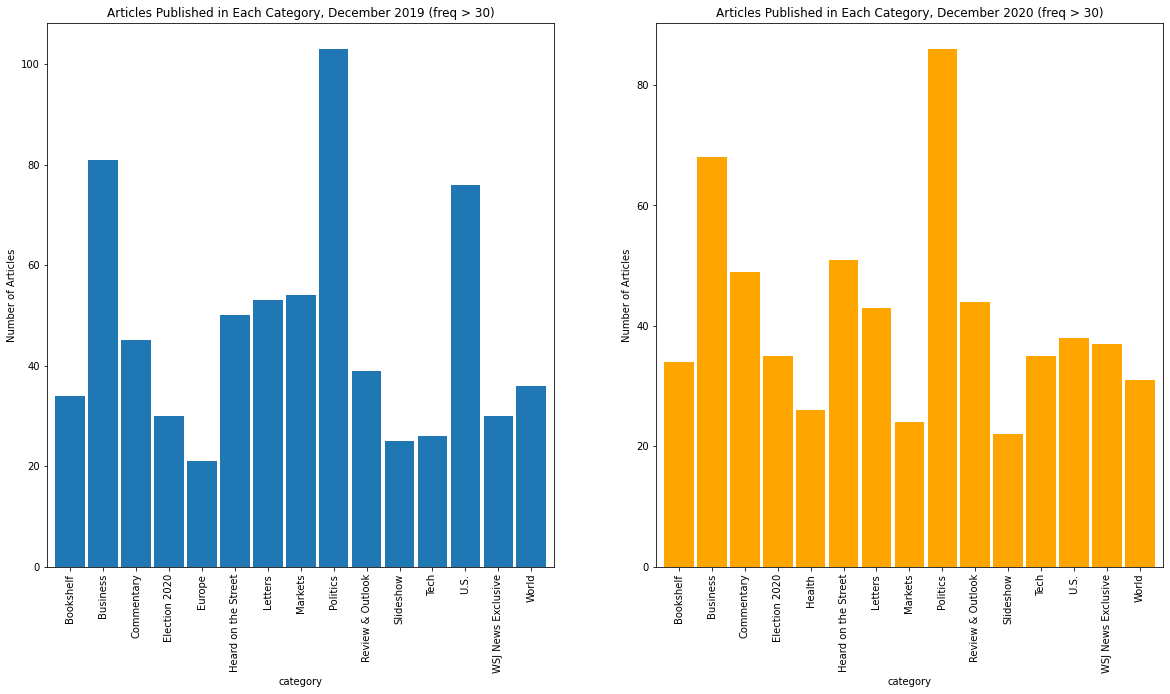

In [ ]:
# Omiting infrequent article categories (occurring less than 20 times)
freq_categories = df.groupby(['category','year'])['title'].count()
freq_categories = freq_categories[freq_categories > 20]

# Categories distribution of December 2020
plt.subplot(1, 2, 1)
plt.ylabel('Number of Articles')
plt.xlabel('Categories')
plt.title('Articles Published in Each Category, December 2019 (freq > 30)')
freq_categories.xs('2019', level='year').plot.bar(width=0.9)

# Categories distribution of December 2020
plt.subplot(1, 2, 2)
plt.ylabel('Number of Articles')
plt.xlabel('Categories')
plt.title('Articles Published in Each Category, December 2020 (freq > 30)')
plt.rcParams["figure.figsize"] = (20, 10)
freq_categories.xs('2020', level='year').plot.bar(width=0.9, color=['orange']);




There are numerous observations on the category distribution of the news articles along with hypothesis as to why it was the case:


1.   **Observation**: As we can see from the above category distribution, the number of news published under category 'Election 2020' increased in 2020.
  
  **Hypothesis**: It maybe due to the post-Elections discussions and Trump's outrageous remarks on the Elections being rigged.


2.   **Observation**: There were significant number of news articles published under the category 'Health' in 2020.
  
  **Hypothesis**: It maybe due to the alarming increase in the coronavirus cases in the U.S.

3. **Observation**: The no. of news in the 'Markets' section decreased in 2020.
  
  **Hypothesis**: It maybe due to the lockdown imposed due to the pandemic which lead the markets to close and there was not much activity to report.

4. **Observation**: The 'U.S' category saw decline in news articles in 2020.
  
  **Hypothesis**: It may also be due to the news agency's focus in elections and covid-19 related articles. 



## **Part 5 – Interaction with the user**
Re-run the cell to prompt user input again

In [ ]:
# Taking inputs from user and validating input
category_exists = False
while not category_exists:
  input_category = input('Enter a category: ')

  # Tearching user supplied category in the dataframe
  search_result = df[df['category'].str.lower() == input_category.lower()][['id','title']]
  
  # If category found
  if len(search_result) != 0:
    category_exists = True

    # Display the id, title, and total no. of articles found
    print(search_result.to_string(index=False), f"\nTotal Articles under category '{input_category}': ", len(search_result))

    # Prompting user to input the ID of the article
    is_id_correct = False
    while not is_id_correct:
      input_id = input('Enter the ID of the article to get the link: ')
      if int(input_id) in search_result['id']: # validating ID
        is_id_correct = True
        link = df.loc[df['id'].astype(str) == input_id, 'link'].values[0]
        print('Link:', link) # Displaying the link to the article
      else:
        print('Please enter correct ID!')
  else:
    print('Sorry! the category you entered does not exist. Try another one!')


Enter a category: politics
   id                                                                                                        title
    8                                                       Trump Administration to Skip House Impeachment Hearing
   43                                                                       Trump Shifts Tone Ahead of NATO Summit
   62                                                 Trump to Put Tariffs on Brazil, Argentina, Citing Currencies
   63                                                              Senate Republicans Push New Privacy Initiative 
   65                                        Trump Administration Proposes Tariffs on $2.4 Billion of French Goods
   69                                                          House GOP Report Defends Trump in Impeachment Probe
   71                                         Senate Confirms Former Lobbyist Dan Brouillette as Energy Secretary 
   75                                                